Need to clone lsst/throughputs and setenv THROUGHPUTS_DIR to point to that directory first.

In [1]:
import sncosmo
import analyzeSN as ans

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Comparison of model and simulated data
We already know how to extract the data from the simulations. The data is the model light curve + noise. The model used here is SALT2, which has a few parameters ['x0', 'x1', 'c', 'z', 't0']. We must estimate the values of these parameters from the data

In [3]:
simdata = ans.SNANASims.fromSNANAfileroot('LSST_Ia', location='ENIGMA_LSSTMAIN/', coerce_inds2int=False)
print simdata.headData.shape

(1622, 78)


In [4]:
hd = simdata.headData.query('REDSHIFT_FINAL > 0.2 and REDSHIFT_FINAL < 0.25').head(5).copy()
#hd = simdata.headData.query('REDSHIFT_FINAL < 0.1').head(5).copy()
snid = hd.index.values[2]
print snid
hd

14121


,IAUC,FAKE,RA,DECL,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,...,SIM_EXPOSURE_r,SIM_EXPOSURE_i,SIM_EXPOSURE_z,SIM_EXPOSURE_Y,SIM_GALFRAC_u,SIM_GALFRAC_g,SIM_GALFRAC_r,SIM_GALFRAC_i,SIM_GALFRAC_z,SIM_GALFRAC_Y
SNID,,,,,,,,,,,,,,,,,,,,,
5930,NULL,2,1.692362,-0.707741,0.2,-9,-9,1,16,8356,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
14049,NULL,2,1.336769,-0.358409,0.2,-9,-9,1,12,20510,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
14121,NULL,2,5.800154,-0.356251,0.2,-9,-9,1,23,20626,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
15396,NULL,2,1.826473,-0.301402,0.2,-9,-9,1,13,22787,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
15824,NULL,2,5.399995,-0.281906,0.2,-9,-9,1,27,23491,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [5]:
lcobj = simdata.get_SNANA_photometry(snid=snid)
print lcobj.lightCurve.shape
#lcobj.lightCurve

(23, 22)


In [6]:
print simdata.headData.ix[snid]
hd['SIM_SALT2x0'] = hd.SIM_SALT2x0 * 10.0**(-0.4 * 0.27)
from collections import OrderedDict as odict
hd['params'] = hd[['SIM_PEAKMJD', 'SIM_SALT2x0', 'SIM_SALT2x1', 'SIM_SALT2c', 'REDSHIFT_FINAL', ]].rename(columns=dict(SIM_PEAKMJD='t0', 
                                                                                    SIM_SALT2x0='x0',
                                                                                    SIM_SALT2x1='x1',
                                                                                    SIM_SALT2c='c',
                                                                                    SIM_MWEBV='ebv',                                   
                                                                                    REDSHIFT_FINAL='z')).apply(odict, axis=1)

IAUC                      NULL    
FAKE                             2
RA                         5.80015
DECL                     -0.356251
PIXSIZE                        0.2
NXPIX                           -9
NYPIX                           -9
SNTYPE                           1
NOBS                            23
PTROBS_MIN                   20626
PTROBS_MAX                   20648
MWEBV                         0.01
MWEBV_ERR                   0.0016
REDSHIFT_HELIO             0.21192
REDSHIFT_HELIO_ERR          0.0005
REDSHIFT_FINAL            0.210506
REDSHIFT_FINAL_ERR          0.0005
HOSTGAL_OBJID                14191
HOSTGAL_PHOTOZ            0.160185
HOSTGAL_PHOTOZ_ERR           0.025
HOSTGAL_SPECZ                    0
HOSTGAL_SPECZ_ERR                0
HOSTGAL_SNSEP                 -999
HOSTGAL_LOGMASS                 -9
HOSTGAL_LOGMASS_ERR             -9
HOSTGAL_MAG_u                  999
HOSTGAL_MAG_g                  999
HOSTGAL_MAG_r                  999
HOSTGAL_MAG_i       

In [7]:
hd['params'].ix[snid]

OrderedDict([('t0', 49576.348),
             ('x0', 7.7306686e-05),
             ('x1', -1.7649484),
             ('c', -0.096813902),
             ('z', 0.21050583)])

In [8]:
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2-extended', effects=[dust, dust], 
                     effect_names=['host', 'mw'], effect_frames=['rest', 'obs'])
model.set(**hd.ix[snid].params)

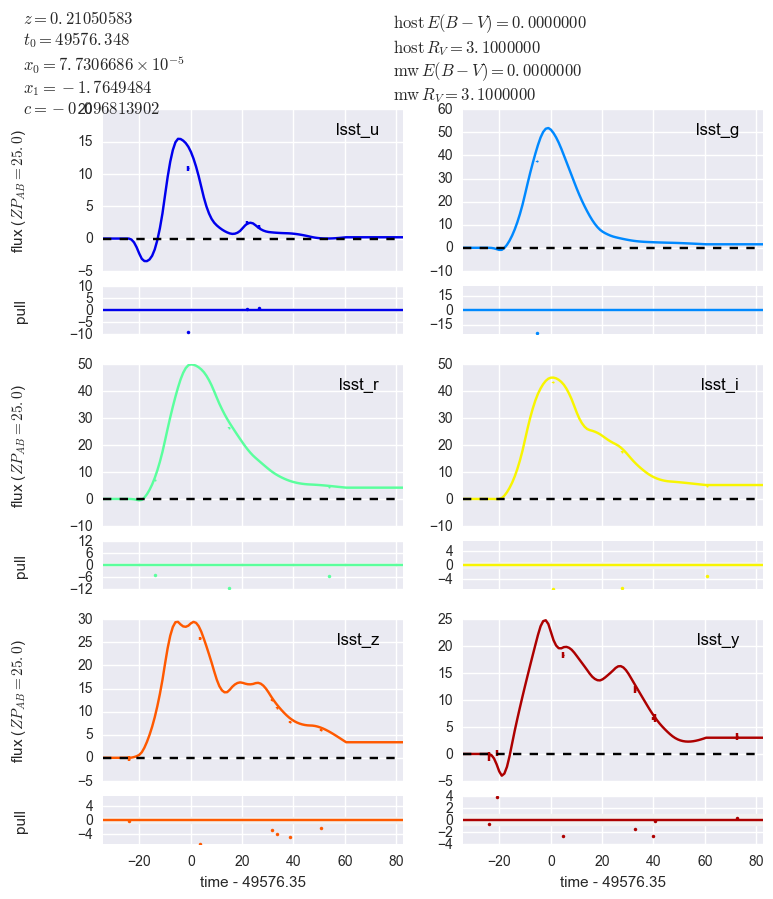

In [9]:
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=model)

### Inferring the model parameters from the data
First we will use a max likelihood method for estimating the model parameters

In [10]:
fitres = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)

In [11]:
fitres[0].parameters

array([  2.10505828e-01,   4.95763707e+04,   6.92959463e-05,
        -1.83681661e+00,  -6.07836620e-02,   0.00000000e+00,
         3.10000000e+00,   0.00000000e+00,   3.10000000e+00])

In [12]:
fitresChar = ans.ResChar.fromSNCosmoRes(fitres)
fitresChar.parameters

z              0.210506
t0         49576.370678
x0             0.000069
x1            -1.836817
c             -0.060784
hostebv        0.000000
hostr_v        3.100000
mwebv          0.000000
mwr_v          3.100000
dtype: float64

In [13]:
fitresChar.vparams

t0    49576.370678
x0        0.000069
x1       -1.836817
c        -0.060784
dtype: float64

In [14]:
fitresChar.salt_covariance_linear()

,mB,x1,c
mB,0.002252,0.006825,0.001110
x1,0.006825,0.088111,0.001640
c,0.001110,0.001640,0.001039


Errors on model parameters. Including mu.

In [15]:
fitresChar.mu_variance_linear()** 0.5

          mB        x1         c
mB  0.002252  0.006825  0.001110
x1  0.006825  0.088111  0.001640
c   0.001110  0.001640  0.001039 [ 1.    0.14 -3.1 ]


0.087012835907070651

### What if we did not know z?

In [16]:
fitres_z = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c', 'z'], guess_z=True, 
                          bounds=dict(z=(0.1, 0.35)),
                          modelcov=True)

In [17]:
fitresChar_z = ans.ResChar.fromSNCosmoRes(fitres_z)
fitresChar_z.parameters

z              0.217245
t0         49576.345172
x0             0.000069
x1            -1.837839
c             -0.067757
hostebv        0.000000
hostr_v        3.100000
mwebv          0.000000
mwr_v          3.100000
dtype: float64

In [18]:
fitresChar_z.mu_variance_linear()**0.5

          mB        x1         c
mB  0.002321  0.006343  0.000933
x1  0.006343  0.084488  0.001879
c   0.000933  0.001879  0.001229 [ 1.    0.14 -3.1 ]


0.1007292534469262

### Now we repeat this in a different method
The maximum likelihood method above is not good if the likelihood are too far from the Gaussian. A method to sample posteriors is better. Such a method can be based on a MCMC run. We do that here by the following code

In [21]:
samples = sncosmo.mcmc_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)

These are samples of these parameters :

In [22]:
ans.ResChar.fromSNCosmoRes(samples).samples.head()

,t0,x0,x1,c
0,49576.210015,0.000078,-2.435445,-0.149629
1,49576.373573,0.000079,-2.425703,-0.165327
2,49576.137107,0.000076,-2.405436,-0.129147
3,49575.809954,0.000079,-2.460816,-0.159886
4,49576.018760,0.000077,-2.386437,-0.134721


In [25]:
import time

tstart = time.time()
samples_z_nomodelcov = sncosmo.mcmc_lc(lcobj.snCosmoLC(), model=model, vparam_names=['z', 't0', 'x0', 'x1', 'c'],
                                       bounds=dict(z=(0.1, 0.5)), modelcov=False)
tend = time.time()
print(tend-tstart)

584.010951996


In [26]:
tstart = time.time()
samples_z = sncosmo.mcmc_lc(lcobj.snCosmoLC(), model=model, vparam_names=['z', 't0', 'x0', 'x1', 'c'],
                           bounds=dict(z=(0.2, 0.6)), modelcov=True)
tend = time.time()
print(tend-tstart)

853.188168049


In [27]:
ans.ResChar.fromSNCosmoRes(samples_z).samples.head()

,z,t0,x0,x1,c
0,0.370704,49589.126525,0.002588,-14.652253,0.286617
1,0.370704,49589.126525,0.002588,-14.652253,0.286617
2,0.370704,49589.126525,0.002588,-14.652253,0.286617
3,0.370704,49589.126525,0.002588,-14.652253,0.286617
4,0.370704,49589.126525,0.002588,-14.652253,0.286617


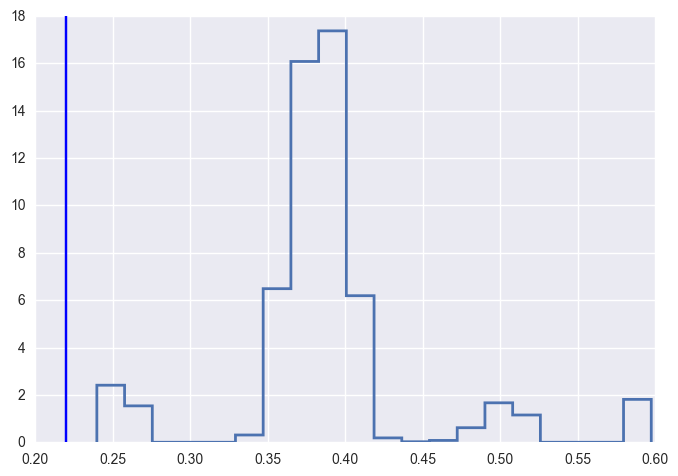

In [28]:
fig, ax = plt.subplots()
ans.ResChar.fromSNCosmoRes(samples_z).samples.z.hist(histtype='step', bins=20, lw=2., alpha=1., normed=1, ax=ax)
ax.axvline(0.22)